In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.layers.wrappers import Bidirectional
from keras_self_attention import SeqSelfAttention
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.display import display, HTML
%matplotlib inline
from pandas.plotting import table
import imgkit
from GrabzIt import GrabzItClient

In [3]:
df = pd.read_csv('./sms_spam.csv', delimiter = ',', encoding = 'UTF-8')
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

X = df.text
Y = df.type
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, stratify=Y, random_state = 0)

In [5]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

## RNN

In [6]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = SeqSelfAttention(name='attention')(layer)
    layer = Bidirectional(LSTM(64))(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [11]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    
    layer = Bidirectional(LSTM(64, return_sequences=True))(layer)
    layer = SeqSelfAttention(name='attention')(layer)
    
    layer = Dense(16)(layer)
    layer = Activation('relu')(layer)
    
    layer = Flatten()(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
model = RNN()
model.summary()
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 128)          58880     
_________________________________________________________________
attention (SeqSelfAttention) (None, 150, 128)          8257      
_________________________________________________________________
dense_4 (Dense)              (None, 150, 16)           2064      
_________________________________________________________________
activation_3 (Activation)    (None, 150, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
__________

## Train the model

In [9]:
hist = model.fit(sequences_matrix,Y_train,batch_size=128, epochs=10,
                  validation_split=0.15,
                  #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
                  callbacks = [ModelCheckpoint("./weights.{epoch:02d}-{val_acc:.2f}-{val_loss:.2f}.h5", monitor='val_loss',
                                               verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)])

Train on 3790 samples, validate on 669 samples
Epoch 1/10
3790/3790 [==============================] - 15s 4ms/step - loss: 0.4147 - acc: 0.8422 - val_loss: 0.3354 - val_acc: 0.8774

Epoch 00001: val_loss improved from inf to 0.33542, saving model to ./weights.01-0.88-0.34.h5


C:\Users\Taisuke\Anaconda3\envs\keras_36\lib\site-packages\keras\utils\io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)


Epoch 2/10
3790/3790 [==============================] - 12s 3ms/step - loss: 0.1842 - acc: 0.9179 - val_loss: 0.0723 - val_acc: 0.9865

Epoch 00002: val_loss improved from 0.33542 to 0.07225, saving model to ./weights.02-0.99-0.07.h5
Epoch 3/10
3790/3790 [==============================] - 12s 3ms/step - loss: 0.0388 - acc: 0.9881 - val_loss: 0.0669 - val_acc: 0.9836

Epoch 00003: val_loss improved from 0.07225 to 0.06686, saving model to ./weights.03-0.98-0.07.h5
Epoch 4/10
3790/3790 [==============================] - 12s 3ms/step - loss: 0.0262 - acc: 0.9934 - val_loss: 0.0531 - val_acc: 0.9851

Epoch 00004: val_loss improved from 0.06686 to 0.05308, saving model to ./weights.04-0.99-0.05.h5
Epoch 5/10
3790/3790 [==============================] - 12s 3ms/step - loss: 0.0171 - acc: 0.9953 - val_loss: 0.0474 - val_acc: 0.9821

Epoch 00005: val_loss improved from 0.05308 to 0.04737, saving model to ./weights.05-0.98-0.05.h5
Epoch 6/10
3790/3790 [==============================] - 12s 3ms/

## Create the test set

In [6]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

## Create the figure for loss and accuracy

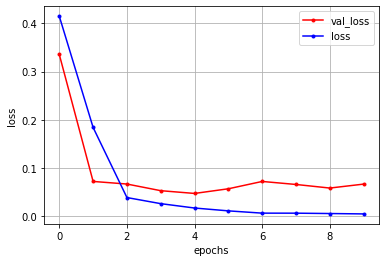

In [11]:
vloss = hist.history['val_loss']
loss = hist.history['loss']

x_len = np.arange(len(loss))

plt.plot(x_len, vloss, marker='.', c='red', label='val_loss')
plt.plot(x_len, loss, marker='.', c='blue', label='loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss.png')
plt.grid()
plt.show()

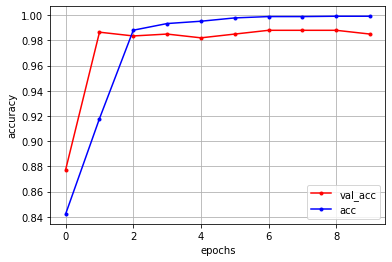

In [12]:
vacc = hist.history['val_acc']
acc = hist.history['acc']

x_len = np.arange(len(vacc))

plt.plot(x_len, vacc, marker='.', c='red', label='val_acc')
plt.plot(x_len, acc, marker='.', c='blue', label='acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.savefig('acc.png')
plt.grid()
plt.show()

## Read the best model

In [9]:
model = load_model("model.h5", custom_objects=SeqSelfAttention.get_custom_objects())

C:\Users\Taisuke\Anaconda3\envs\keras_36\lib\site-packages\keras\utils\io_utils.py:186: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.data = h5py.File(path,)


In [10]:
accr = model.evaluate(test_sequences_matrix,Y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1115/1115 [==============================] - 35s 31ms/step
Test set
  Loss: 0.071
  Accuracy: 0.982


In [16]:
#emodel = Model(inputs=model.input, outputs=[model.output, model.layers[2].output])
emodel = Model(inputs=model.input, outputs=[model.output, model.layers[3].output])
emodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 128)          58880     
_________________________________________________________________
attention (SeqSelfAttention) (None, 150, 128)          8257      
_________________________________________________________________
dense_1 (Dense)              (None, 150, 16)           2064      
_________________________________________________________________
activation_1 (Activation)    (None, 150, 16)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2400)              0         
__________

## predict using test set

In [17]:
predict=emodel.predict(test_sequences_matrix)

In [18]:
tok.word_index

{'i': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'the': 5,
 'u': 6,
 'and': 7,
 'is': 8,
 'in': 9,
 'me': 10,
 'my': 11,
 'your': 12,
 'for': 13,
 'it': 14,
 'of': 15,
 'call': 16,
 'have': 17,
 'on': 18,
 '2': 19,
 'now': 20,
 'that': 21,
 'are': 22,
 'so': 23,
 'not': 24,
 'but': 25,
 'or': 26,
 'can': 27,
 'ur': 28,
 'do': 29,
 "i'm": 30,
 'be': 31,
 'will': 32,
 'if': 33,
 'at': 34,
 'get': 35,
 'just': 36,
 'with': 37,
 'we': 38,
 'no': 39,
 'this': 40,
 '4': 41,
 'gt': 42,
 'lt': 43,
 'up': 44,
 'ok': 45,
 'when': 46,
 'how': 47,
 'out': 48,
 'free': 49,
 'go': 50,
 'from': 51,
 'know': 52,
 'all': 53,
 'what': 54,
 'come': 55,
 'like': 56,
 'then': 57,
 'good': 58,
 'was': 59,
 'got': 60,
 'am': 61,
 'its': 62,
 'time': 63,
 'love': 64,
 'only': 65,
 'send': 66,
 'day': 67,
 'he': 68,
 'there': 69,
 'text': 70,
 'by': 71,
 'want': 72,
 'txt': 73,
 'going': 74,
 'one': 75,
 'as': 76,
 'lor': 77,
 'r': 78,
 'need': 79,
 'ü': 80,
 "i'll": 81,
 'back': 82,
 'home': 83,
 'about': 84,
 'n': 85

In [19]:
keys = [k for k, v in tok.word_index.items() if v == 106]
print(keys)

['later']


In [20]:
word_list = []
word_seq = ''

for i, j in enumerate(test_sequences[0]):
    keys = [k for k, v in tok.word_index.items() if v == j]
    word_list.append(keys[0])
    word_seq += keys[0]
    if i < len(test_sequences[0]):
        word_seq += ' '

print(word_list)
print(word_seq)

['do', 'not', 'b', 'late', 'love', 'mum']
do not b late love mum 


In [32]:
spam_list=[]

for i in range(len(Y_test)):
    if Y_test[i] == 1:
        #print(i)
        spam_list.append(i)

In [38]:
X_test_list = X_test.values.tolist()

In [46]:
for i in spam_list:
    print(i, X_test_list[i])
    print('\n')

6 Please CALL 08712402972 immediately as there is an urgent message waiting for you


13 U can WIN £100 of Music Gift Vouchers every week starting NOW Txt the word DRAW to 87066 TsCs www.Idew.com SkillGame, 1Winaweek, age16. 150ppermessSubscription


14 FreeMsg>FAV XMAS TONES!Reply REAL


22 You are a winner you have been specially selected to receive £1000 cash or a £2000 award. Speak to a live operator to claim call 087123002209am-7pm. Cost 10p


33 Hello from Orange. For 1 month's free access to games, news and sport, plus 10 free texts and 20 photo messages, reply YES. Terms apply: www.orange.co.uk/ow


39 Got what it takes 2 take part in the WRC Rally in Oz? U can with Lucozade Energy! Text RALLY LE to 61200 (25p), see packs or lucozade.co.uk/wrc & itcould be u!


49 For your chance to WIN a FREE Bluetooth Headset then simply reply back with "ADP"


52 CDs 4u: Congratulations ur awarded £500 of CD gift vouchers or £125 gift guaranteed & Freeentry 2 £100 wkly draw xt MUSIC to 87066

## Visualize the weight

In [49]:
# http, com
#index = 662
index = 1022


# miss sample
#index = 0

#token = X_test.values.tolist()[index].split()
word_list = []

for i in test_sequences[index]:
    keys = [k for k, v in tok.word_index.items() if v == i]
    word_list.append(keys[0])
    
token = word_list

weight = [w.max() for w in predict[1][0][-len(token):]] 

df = pd.DataFrame([token, weight], index=['token', 'weight'])
mean = np.array(weight).mean()
print(df.shape, mean)
df = df.T

df['rank'] = df['weight'].rank(ascending=False)

df['normalized'] = df['weight'].apply(lambda w: max(w - mean, 0))
df['weight'] = df['weight'].astype('float32')
df['attention'] = df['normalized'] > 0
df = df.style.background_gradient(cmap = 'Blues', subset=['normalized'])

predict_spam = model.predict(test_sequences_matrix)
if predict_spam[index] <= 0.5:
    print("prediction: ham")
else:
    print("prediction: spam")

if Y_test[index] == 0:
    print("answer: ham")
else:
    print("answer: spam")

(2, 24) 0.117314756
prediction: spam
answer: spam


In [50]:
print("original message: ",X_test.values.tolist()[index])
display(df)

original message:  URGENT We are trying to contact you Last weekends draw shows u have won a £1000 prize GUARANTEED Call 09064017295 Claim code K52 Valid 12hrs 150p pm


,token,weight,rank,normalized,attention
0,urgent,0.117312,24,0,False
1,we,0.117312,23,0,False
2,are,0.117312,22,0,False
3,trying,0.117313,21,0,False
4,to,0.117313,20,0,False
5,contact,0.117313,19,0,False
6,you,0.117313,18,0,False
7,last,0.117313,17,0,False
8,draw,0.117313,16,0,False
9,shows,0.117314,15,0,False
